## Tutorial for Homework 3 
## Geoph 426-526
### Fall 2020, M D Saccchi
### msacchi@ualberta.ca

# 1) Brief Summary and Learning Goals

I will first generate a synthetic reflectivity series $q_k$ and then convolve it with a minimum phase wavelet $w_k$ to compute the synthetic seismic trace. The wavelet is provided. In assignment 4, we will learn a method to estimate the wavelet directly from the seismic trace. The seismogram is denoted by $s_k$ and given by 

\begin{equation}
s_k = w_k \ast q_k  \tag{1}
\end{equation}
where $\ast$ denots convolution. 
Similarly, we call the observed seismograph $s_{obs}$

\begin{equation}
s_k^{obs} = w_k \ast q_k  + n_k \tag{2}
\end{equation}
where $n_k$ is Gaussian additive noise.  In Homework 3, you will learn the following:

* Design the wavelet inverse filter via the least-squares method.
* Given the designed filter, you will apply it to the wavelet and to the seismic trace. What appears to be a good filter (one that inverts the wavelet) will fail to recover the reflectivy when the seismic trace is contaminated by additive noise. In other words, the noise in the seismogram is amplifed by the filter. 
* You will learn how to insert  a tradeoff paramter $\mu$ to control noise amplification. 
* You will also learn to examine your results in the frequency domain. 

Chapter 3 of my notes contain the theory of inverse filters, inverse filter design via the method of least-squares and regularized least-squares. 




In [1]:
using PyPlot, SeisMain, SeisProcessing, LinearAlgebra, DelimitedFiles 

# Include file where I save all functions that I will be using for this project

include("g426_526_codes.jl")

spectrum (generic function with 1 method)

# 2)  Read wavelet, generate synthetic seismogram and inverse filter

In [2]:
# Reflectivity 

# I propose a synthetic reflectivity that consists of 160 samples
# at sampling rate dt seconds. The reflectivity is composed of 4 reflectors
# at t=(n-1)*dt seconds where n=11,51,61,68


dt = 0.004
 q = zeros(160)

q[11] =  1.0
q[51] = -0.5
q[61] =  0.4
q[68] = -0.4
# Read a supplied minimum phase wavelet 

w = readdlm("wavelet.txt")

# Compute the seismic trace

s = convolution(q,w)

# Add noise to the seismic trace

s_obs = s + 0.05*randn(size(s))

# Save seismic trace 

open("seismogram_no_noise.txt", "w") do io
           writedlm(io, s)
       end

# Save noisy seismic trace

open("seismogram_with_noise.txt", "w") do io
           writedlm(io, s_obs)
       end

# Save reflectivity series

open("reflectivity.txt", "w") do io
           writedlm(io, q)
       end

# Inversion: mu is tradeoff parameter of the least-squares inverse filter
#            nf is the filter lenght


mu= (0.0, 0.01, 0.1, 1.0, 10.0)


nf = 80

# Compute filter f,  o is the actual output and e is the error (difference between
# desired and actual output). Choose one tradeoff parameter from the vector mu[]\
# to explore the deconvolution process

# Recomdendation: Run the whole notebook first with mu[1]=0, then try mu[2], mu[3],
# and so on to explore results

mu_chosen = mu[1]

f,o,e= ls_decon(w,nf,mu_chosen);



# 3) Results for the case where the seismogram does not contain additive noise


Below I am displaying the wavelet, the inverse filter and the actual output $f_k \ast w_k$ which should resemble a spike at $t=0$ when $\mu=0$. Then, I am aslo showing the application of the filter to the seismogram $s_k$ to obitain the reflectivity $f_k \ast s_k$. In this case, I am using the ideal seismogram (no noise) and therefore, the reflectivity is recovered. 

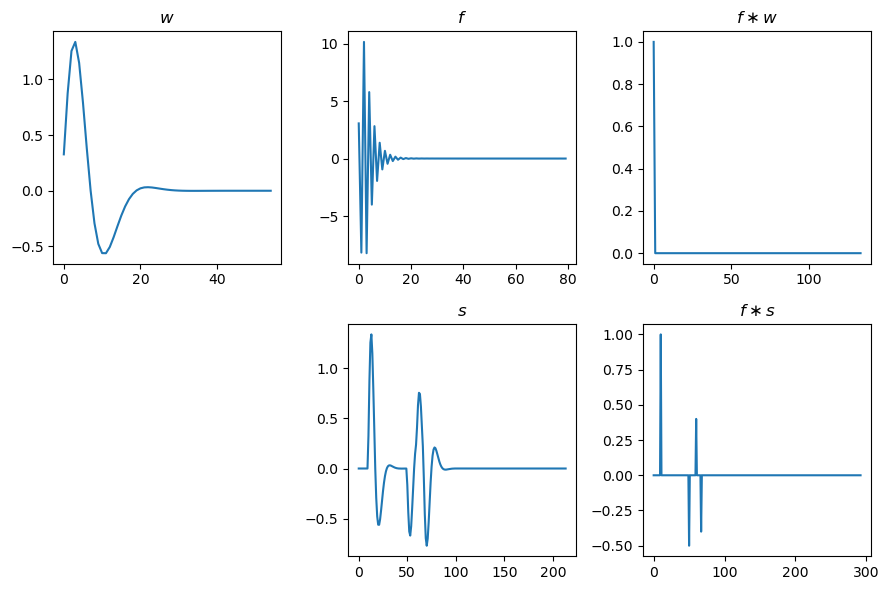

In [3]:
figure(1, figsize=(9,6))
subplot(231); plot(w); title(L"w")
subplot(232); plot(f); title(L"f")
subplot(233); plot(convolution(w,f)); title(L"f \ast w")

subplot(235);

plot(s); title(L"s")
subplot(236); plot(convolution(f,s)); title(L"f \ast s")

tight_layout()



# 4) Results for the case where the seismogram is corrupted by Gaussian noise


Below I am displaying the wavelet, the inverse filter and the actual output $f_k \ast w_k$ which should resemble a spike at $t=0$ when $\mu=0$. Then, I am aslo showing the application of the filter to the seismogram $s_k^{obs}$ to obitain the reflectivity $f_k \ast s_k^{obs}$. In this case, I am using the  seismogram corrupted by noise. Therefore, the reflectivity $f_k \ast s_k^{obs}$ will lead to a solution where the noise is amplified. This amplifcation can be controled by increasing $\mu$. Run the notebook for different values of $\mu$ and examine the resulting reflecivity $f_k \ast s_k^{obs}$.

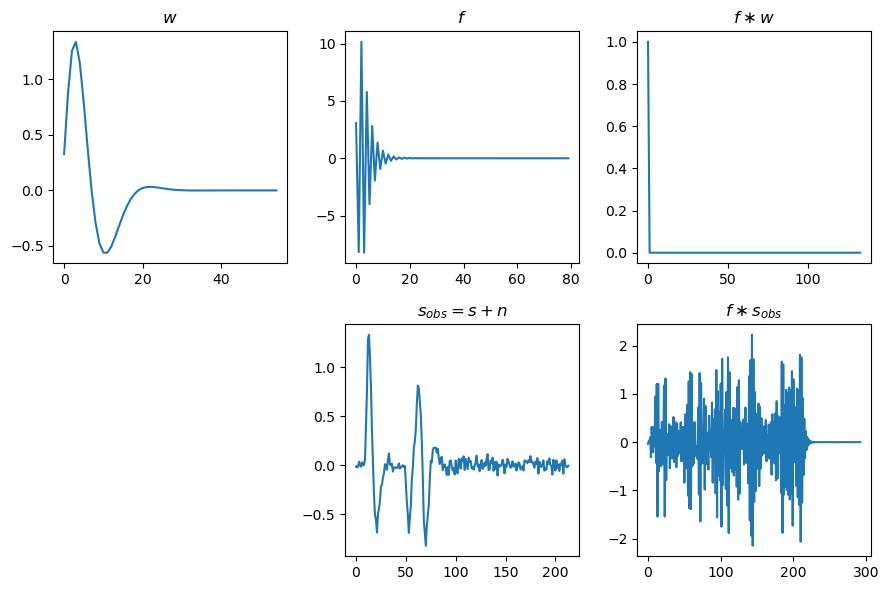

In [4]:

figure(2, figsize=(9,6))
subplot(231); plot(w); title(L"w")
subplot(232); plot(f); title(L"f")
subplot(233); plot(convolution(w,f)); title(L"f \ast w")

subplot(235); plot(s_obs); title(L"s_{obs}=s+n")
subplot(236); plot(convolution(f,s_obs)); title(L"f \ast s_{obs}")

tight_layout()

# 5) Compute and plot spectra 

One can explore how the tradeoff parameter $\mu$ shapes the spectrum of the filter and the spectrum of the actual output and, consequently, the spectrum of the deconvolved reflectivity. When $\mu$ is small the filter amplifies high frequencies and therefore, increases the noise in the deconvolved signal. 


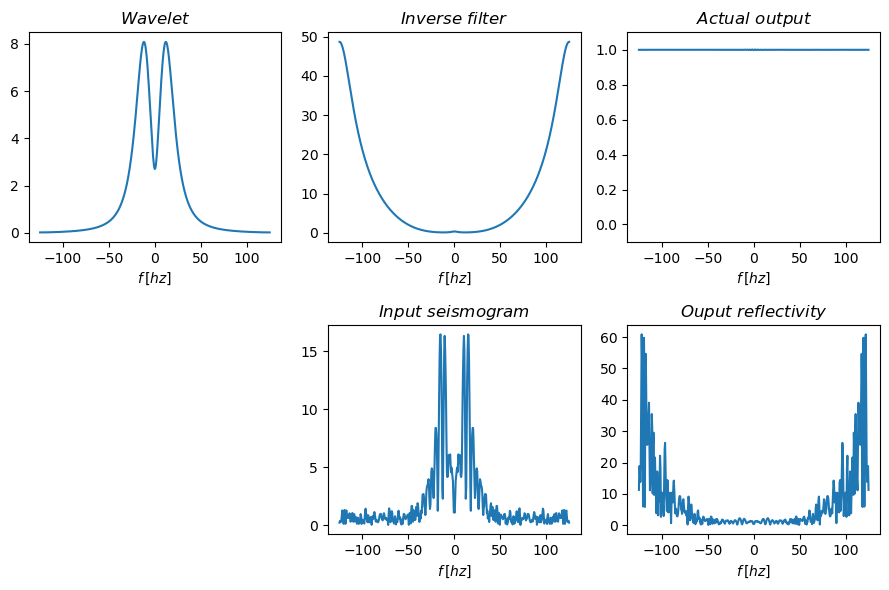

In [5]:
dt = 4.0/1000.
omega,freq,W = spectrum(w,dt)
omega,freq,F = spectrum(f,dt);
o=convolution(f,w)
omega,freq,O = spectrum(o,dt)
omega,freq,S = spectrum(s_obs,dt)
omega,freq,Q = spectrum(convolution(f,s_obs),dt)
figure(3, figsize=(9,6))
subplot(231); plot(freq,W); title(L"Wavelet");xlabel(L"f\, [hz]"); 
subplot(232); plot(freq,F);title(L"Inverse \,\,filter");xlabel(L"f\, [hz]")
subplot(233); plot(freq,O);title(L"Actual \,\,output");xlabel(L"f\, [hz]"); ylim([-0.1,1.1])

subplot(235); plot(freq,S);title(L"Input\,\,seismogram");xlabel(L"f\, [hz]")
subplot(236); plot(freq,Q);title(L"Ouput\,\, reflectivity");xlabel(L"f\, [hz]"); 

tight_layout()

# 6) Evaluate trade-off curve to understand the behaviour of the filter norm, and error (desired minus actual output)

In [6]:
# Compute trade off curve 

# Adopt a nice scale for mu and evaluate filter energy and energgy of error 
# for different values of mu

mu = [2.0^k for k=-4:4]

Nf = zeros(length(mu))
Ne = zeros(length(mu))
for k = 1:length(mu)
    f,o,e = ls_decon(w,nf,mu[k])
    Nf[k] = f'*f
    Ne[k] = e'*e
end


# 7) Display trade-off diagrams 

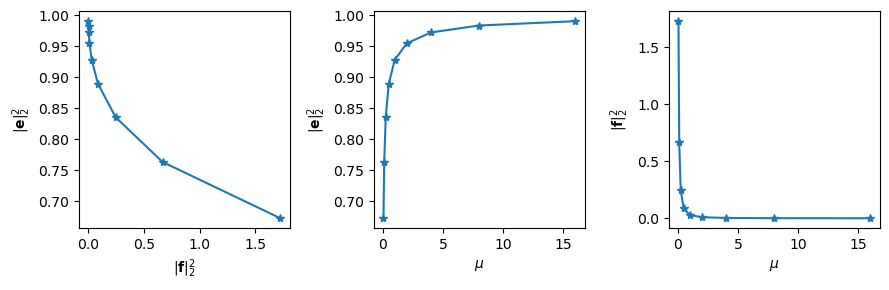

In [7]:
figure(4, figsize=(9,3))
subplot(131);plot(Nf,Ne,"*-")
ylabel(L"\|{\bf e}\|_2^2")
xlabel(L"\|{\bf f}\|_2^2")

subplot(132);plot(mu,Ne,"*-")
xlabel(L"\mu")
ylabel(L"\|{\bf e}\|_2^2")

subplot(133);plot(mu,Nf,"*-")
xlabel(L"\mu")
ylabel(L"\|{\bf f}\|_2^2")

tight_layout()